In [1]:
# import libraries
import shutil
import os
import re
import cv2
from PIL import Image
import time
import numpy as np
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, DirectoryIterator
from sklearn.model_selection import train_test_split
import glob
from keras.preprocessing import image
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize, LabelEncoder
from keras.utils import to_categorical
from tqdm import tqdm
import math 

import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io as io
%matplotlib inline

from keras import backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils

from os import listdir, makedirs
from os.path import join

from keras.models import Model

from keras.regularizers import l2
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


In [2]:
NUM_CLASSES = 30 

data_dir = '/floyd/input/deep_fashion_subset/'


In [3]:
#define paths for images
train_path = "/floyd/input/deep_fashion_subset/train"
val_path = "/floyd/input/deep_fashion_subset/val"
test_path = "/floyd/input/deep_fashion_subset/test"

In [6]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

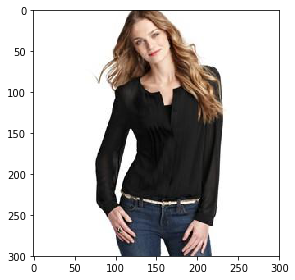

In [9]:
pleated_blouse = io.imread(data_dir +'train/Blouse/Sheer_Pleated-Front_Blouse/img_00000001.jpg')

io.imshow(pleated_blouse)
io.show()

In [10]:
batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), batch_size=10)

Found 207718 images belonging to 30 classes.


In [11]:
imgs, labels = next(batches)

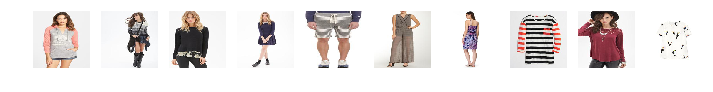

In [12]:
plots(imgs)

In [18]:
# define function to get list of labels from folder names
def get_labels(folder_name):

    label_list = []
    for labels in glob.glob(folder_name + '/*'):
        label = labels.split('/')[-1]
        for folder in glob.glob(labels + '/*'):
            for img_path in glob.glob(folder + '/*'):
                    
                label_list.append((label))
                    
    return label_list

In [19]:
#create list of labels 
train_labels = get_labels(train_path)
val_labels = get_labels(val_path)
test_labels = get_labels(test_path)

In [20]:
# create dict of training labels
labels_dict = {}
for i in train_labels:
    if i in labels_dict:
        labels_dict[i] += 1
    else:
        labels_dict[i] = 1


        
labels_dict

{'Poncho': 579,
 'Tank': 11204,
 'Leggings': 3571,
 'Jacket': 7548,
 'Hoodie': 2910,
 'Sweatshorts': 781,
 'Blouse': 17752,
 'Flannel': 224,
 'Jumpsuit': 4464,
 'Shorts': 14195,
 'Coat': 1539,
 'Jeggings': 443,
 'Sweater': 9517,
 'Joggers': 3260,
 'Chinos': 374,
 'Top': 7270,
 'Parka': 491,
 'Sweatpants': 2224,
 'Romper': 5425,
 'Blazer': 5408,
 'Skirt': 10794,
 'Kimono': 1637,
 'Culottes': 359,
 'Jeans': 5126,
 'Cutoffs': 1177,
 'Tee': 26653,
 'Cardigan': 9606,
 'Henley': 521,
 'Dress': 52132,
 'Jersey': 534}

# Using bottleneck features of VGG16 to train dense layers

In [21]:
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

553467904/553467096 [==============================] - 37s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_p

In [18]:
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = train_path
validation_data_dir = val_path
nb_train_samples = 207718
nb_validation_samples = 39720
epochs = 50
batch_size = 32

    
datagen = ImageDataGenerator(rescale=1. / 255)

# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))  

bottleneck_features_train = model.predict_generator(
    generator, predict_size_train)

np.save('bottleneck_features_train.npy',bottleneck_features_train)

num_classes = len(generator.class_indices)
train_labels = generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 207718 images belonging to 30 classes.
Found 39720 images belonging to 30 classes.


In [27]:
generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

bottleneck_features_validation = model.predict_generator(
    generator, predict_size_validation)

np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

num_classes = len(generator.class_indices)
validation_labels = generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)


Found 39720 images belonging to 30 classes.


In [ ]:
def train_top_model():
    train_data = np.load('bottleneck_features_train.npy')
    tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)


    validation_data = np.load('bottleneck_features_validation.npy')
    

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[tbCallBack])
    model.save_weights(top_model_weights_path)



train_top_model()

Train on 207718 samples, validate on 39720 samples
Epoch 1/50
207718/207718 [==============================] - 42s 203us/step - loss: 2.7688 - acc: 0.2473 - val_loss: 2.7022 - val_acc: 0.2531
Epoch 2/50
207718/207718 [==============================] - 43s 207us/step - loss: 2.7319 - acc: 0.2510 - val_loss: 2.7010 - val_acc: 0.2531
Epoch 3/50
207718/207718 [==============================] - 42s 200us/step - loss: 2.7171 - acc: 0.2510 - val_loss: 2.7013 - val_acc: 0.2531
Epoch 4/50
207718/207718 [==============================] - 42s 200us/step - loss: 2.6973 - acc: 0.2510 - val_loss: 2.6790 - val_acc: 0.2531
Epoch 5/50
207718/207718 [==============================] - 42s 200us/step - loss: 2.6844 - acc: 0.2510 - val_loss: 2.6756 - val_acc: 0.2531
Epoch 6/50
207718/207718 [==============================] - 42s 201us/step - loss: 2.6774 - acc: 0.2510 - val_loss: 2.6704 - val_acc: 0.2531
Epoch 7/50
207718/207718 [==============================] - 42s 203us/step - loss: 2.6736 - acc: 0.2510

# Clearly not working, will try resnet50

In [4]:
model_resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

94658560/94653016 [==============================] - 6s 0us/step


In [5]:
for layer in model_resnet.layers[:-12]:
    
    layer.trainable = False

In [6]:
x = model_resnet.output
x = Dense(512, activation='elu', kernel_regularizer=l2(0.001))(x)
y = Dense(30, activation='softmax', name='img')(x)

In [7]:
final_model = Model(inputs=model_resnet.input,
                    outputs=y)

In [8]:
print(final_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
batch_size = 32

In [10]:
opt = SGD(lr=0.0001, momentum=0.9, nesterov=True)

In [11]:
final_model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics= ['accuracy', 'top_k_categorical_accuracy']) # default: top-5                             

In [12]:
train_datagen = ImageDataGenerator(rotation_range=30.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator()

In [13]:
#reads images from labeled directory
train_generator = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=(200, 200),  # all images will be resized 
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

Found 207718 images belonging to 30 classes.


In [14]:
#reads images from labeled directory
validation_generator = test_datagen.flow_from_directory(
        val_path,
        target_size=(200, 200),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

Found 39720 images belonging to 30 classes.


In [15]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               patience=12,
                               factor=0.5,
                               verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss',
                              patience=30,
                              verbose=1)
checkpoint = ModelCheckpoint('./models/model.h5')

Instructions for updating:
Use the retry module or similar alternatives.


In [ ]:
#final_model.fit_generator(train_generator,
                          #steps_per_epoch=6491,
                          #epochs=40, validation_data=validation_generator,
                          #validation_steps=1241,
                          #verbose=2,
                          #shuffle=True,
                          #callbacks=[lr_reducer, checkpoint, tensorboard],
                          #workers=12)

In [ ]:
#Save Weights + Architecture
final_model.save_weights('model_weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
test_datagen = ImageDataGenerator()

#reads images from labeled directory
test_generator = test_datagen.flow_from_directory(
        test_path,  # this is the target directory
        target_size=(200, 200),  # all images will be resized 
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

scores = new_model_2.evaluate_generator(test_generator, steps=1241)

print('Multi target loss: ' + str(scores[0]))
print('Image loss: ' + str(scores[1]))
print('Image accuracy: ' + str(scores[2]))
print('Top-5 image accuracy: ' + str(scores[3]))
